This notebook shows how to deploy [Keras based Stable Diffusion](https://github.com/keras-team/keras-cv/tree/master/keras_cv/models/stable_diffusion) on Hugging Face Endpoint.with custom handler.

# Setup

## Install dependencies for local dev environment

`git-lfs` is only needed for clone, commit, push operations with Hugging Face Remote Repository. 

In [ ]:
!sudo apt-get update
!sudo apt-get install git-lfs

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,568 kB]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:14 http://p

## Clone a model repository from Hugging Face Hub

You need to create a Model repository on Hugging Face Hub first.

In [ ]:
REPO_ID = "chansung/sd-kerascv"

In [ ]:
!git lfs install
!git clone https://huggingface.co/{REPO_ID}

Error: Failed to call git rev-parse --git-dir --show-toplevel: "fatal: not a git repository (or any of the parent directories): .git\n"
Git LFS initialized.
Cloning into 'sd-kerascv'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 31 (delta 8), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (31/31), done.


## Authenticate with Hugging Face Access Token

In order to proceed this step successfully, you need your own Hugging Face Access Token with `WRITE` privilege. If you don't have one, you can get one from your [settings/access token](https://huggingface.co/settings/tokens) page.

In [ ]:
# setup cli with token
!huggingface-cli login
!git config --global credential.helper store


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/tokens .
    
Token: 
Add token as git credential? (Y/n) Y
Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


# Test without custom handler

In this section, we simply generate images with Stable Diffusion v1.4 ported into KERAS-CV without any Hugging Face related stuffs. The main purpose of this section is to ensure if the encoded images can be suffecessfully restored with `base64`.
- Stable Diffusion generates a bunch of images at once, and image data is commonly passed to server/client after being encoded as string values with `base64`.

After this section, you will see how this could be integrated into [`custom handler`](https://huggingface.co/docs/inference-endpoints/guides/custom_handler) for Hugging Face Endpoint.

In [ ]:
!pip install keras-cv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 394 kB 4.1 MB/s 


In [ ]:
import time
import base64
import keras_cv
from tensorflow import keras
import matplotlib.pyplot as plt

In [ ]:
model = keras_cv.models.StableDiffusion(img_width=512, img_height=512)

1356917/1356917 [==============================] - 0s 0us/step
By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE
198180272/198180272 [==============================] - 3s 0us/step


In [ ]:
def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

25/25 [==============================] - 19s 405ms/step


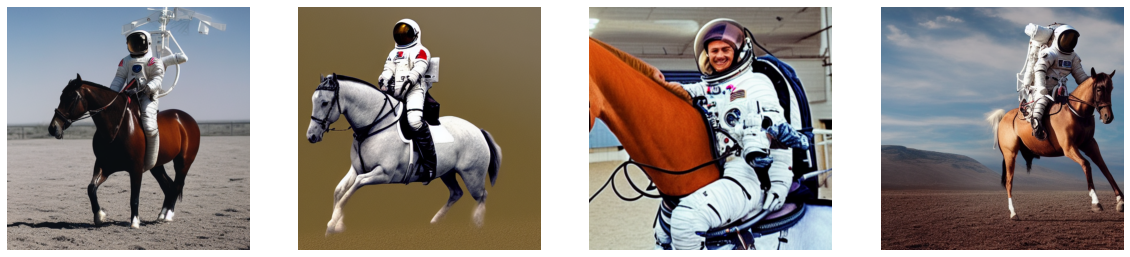

In [ ]:
images = model.text_to_image("photograph of an astronaut riding a horse", batch_size=4)
plot_images(images)

In [ ]:
images.shape

In [ ]:
images.dtype

## Convert np.ndarray to base64 string

In [ ]:
images_b64 = base64.b64encode(images.tobytes())

In [ ]:
images_b64str = images_b64.decode()

## Restore base64 string back to np.ndarray

In [ ]:
import numpy as np

images_decoded = base64.b64decode(images_b64str)
images_restored = np.frombuffer(images_decoded, dtype="uint8")
images_restored_reshaped = np.reshape(images_restored, (4, 512, 512, 3))

In [ ]:
print(type(images_restored))
print(images_restored.shape)
print(images_restored_reshaped.shape)

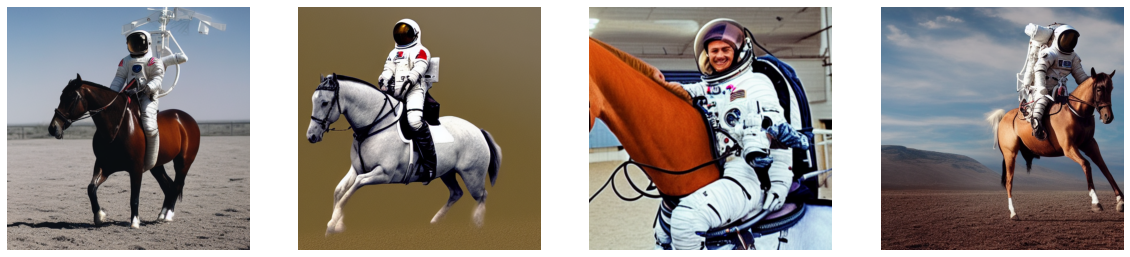

In [ ]:
plot_images(images)

# Test with custom handler

In this section, we will verity if everything works OK with [`custom handler`](https://huggingface.co/docs/inference-endpoints/guides/custom_handler) within local environment. Here is what you should do:
1. create `requirements.txt` with appropriate dependencies listed. In this example notebook, `keras-cv`, `tensorflow`, and `tensorflow_Datasets` are required packages to run Keras based Stable Diffusion.

2. create `handler.py` file that implements custom handler.
- You need to define `EndpointHandler` class with `__init__` and `__call__` methods. `__init__` method is called when initializing and setting the server up and running, and `__call__` method is called whenever requests are arrived.

3. write test code to do the following:
  - Create `EndpointHandler` instance
  - Construct a sample payload
  - Call `__call__` method of `EndpointHandler` instance by passing the payload
  - Decode the generated images

In [ ]:
%cd /content/sd-kerascv

/content/sd-kerascv


In [ ]:
!echo "keras-cv" >> requirements.txt
!echo "tensorflow" >> requirements.txt
!echo "tensorflow_datasets" >> requirements.txt

In [ ]:
%%writefile handler.py
from typing import Dict, List, Any
import base64
import keras_cv

class EndpointHandler():
    def __init__(self, path=""):
        self.sd = keras_cv.models.StableDiffusion(img_width=512, img_height=512)
    
    def __call__(self, data: Dict[str, Any]) -> str:
        # get inputs 
        prompt = data.pop("inputs", data)
        batch_size = data.pop("batch_size", 1)

        # run normal prediction
        images = self.sd.text_to_image(prompt, batch_size=batch_size)
        return base64.b64encode(images.tobytes()).decode()

In [ ]:
import base64
import numpy as np
from handler import EndpointHandler

# init pipeline
batch_size = 4
my_handler = EndpointHandler(path=".")

# prepare sample playoad
sd_payload = {"inputs": "photograph of an astronaut riding a horse",
              "batch_size": batch_size}

# test the pipeline
response = my_handler(sd_payload)

decoded = base64.b64decode(response)
restored = np.frombuffer(decoded, dtype="uint8")
restored_reshaped = np.reshape(restored, (batch_size, 512, 512, 3))

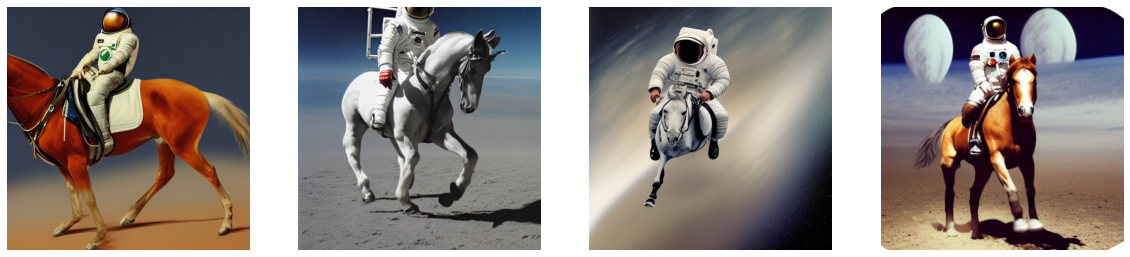

In [ ]:
import matplotlib.pyplot as plt

plot_images(restored_reshaped)

If you think it is OK to be deployed in production environment, add/commit/push the changes (`requirements.txt` and `handler.py`) to the remote repository of Hugging Face Model Hub.

In [ ]:
!git config --global user.email "deep.diver.csp@gmail.com"
!git config --global user.name "Chansung Park"

In [ ]:
!git add * 
!git commit -m "add custom handler"
!git push

# Test with Hugging Face endpoint

In the final section, we will test the custom handler that is actually deployed on [Hugging Face Endpoint](https://huggingface.co/inference-endpoints). Hugging Face Endpoint is a kind of serverless platform that let you deploy your model or custom handler in the cloud. 
- Currently supported cloud service platform are AWS and Azure.

So, in order to follow-up this section successfully, you need to create an endpoint beforehand with the following steps:
1. Add payment method if you have not set yet in [Settings/Billing](https://huggingface.co/settings/billing/payment). Once an endpoint is created, you will need to pay for how long it has been up and run, so this step is a mandatory. Also don't forget to check out the [pricing table](https://huggingface.co/pricing#endpoints).

2. Connect to the [Hugging Face Endpoint UI Dashboard](https://ui.endpoints.huggingface.co/) and create a endpoint. It is flexible how to configure the endpoint, so feel free to look around.
- Just don't forget to select the right repository under `Model Repository` section.

<img src="https://i.ibb.co/kHMTnMd/2022-12-16-2-51-17.png"/>



The code below sends a request to the endpoint. Here are two thing you need to know:
- `HF_TOKEN`: if you created the endpoint with `Private` or `Protected` security level, you need Hugging Face Access Token, so please put it in `HF_TOKEN` variable. However, if the security level of the endpoint is `Public`, you don't have to.

- `ENDPOINT_URL`: everytime you create a new endpoint, you will get a unique URL for the endpoint, and that is where the requests should be sent. so please replace the placeholder value in `ENDPOINT_URL` variable with your own URL.

In [ ]:
import json
import requests as r

HF_TOKEN = ""
ENDPOINT_URL = "https://qlsx73evofa6wnew.us-east-1.aws.endpoints.huggingface.cloud"
PROMPT = "photograph of an astronaut riding a horse"
BATCH_SIZE = 4

payload = {"inputs": PROMPT,
           "batch_size": BATCH_SIZE}
headers = {
    "Authorization": f"Bearer {HF_TOKEN}",
    "Content-Type": "application/json",
}
response = r.post(ENDPOINT_URL, headers=headers, json=payload)


In [ ]:
import base64
import numpy as np

decoded_hfe = base64.b64decode(response.content)
restored_hfe = np.frombuffer(decoded_hfe, dtype="uint8")
restored_reshaped_hfe = np.reshape(restored_hfe, (BATCH_SIZE, 512, 512, 3))

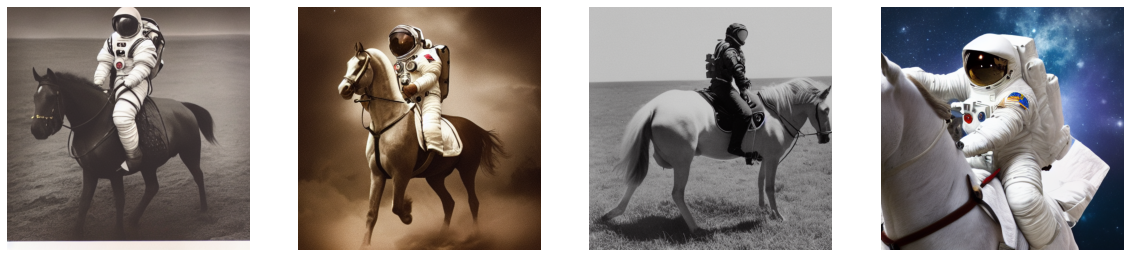

In [ ]:
import matplotlib.pyplot as plt

plot_images(restored_reshaped_hfe)